# Modeling

The purpose of this notebook will be creating the model that best predicts games. There will be three subsets of modeling: one using only "classical" stats, one using "sabermetric" stats, and one using both.

In [216]:
import datetime
import matplotlib.pyplot as plt
import pickle
import polars as pl
import pprint

from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

## Loading the Data

This is loading the parquet file created in the EDA notebook.

In [217]:
df = pl.read_parquet("dataset_current.parquet")

In [218]:
df.describe()

statistic,pitcher_era_comp,pitcher_win_percentage_comp,pitcher_win_comp,pitcher_losses_comp,pitcher_innings_pitched_comp,pitcher_k_nine_comp,pitcher_bb_nine_comp,pitcher_k_bb_diff_comp,pitcher_whip_comp,pitcher_babip_comp,pitcher_k_bb_ratio_comp,winning_team
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.032959,-0.009209,-0.008966,-0.028691,0.117155,0.114071,0.036844,0.001594,0.006922,0.001019,0.024861,0.524806
"""std""",2.615378,0.36593,3.78369,3.152297,42.295013,2.749947,1.695493,0.089692,0.399619,0.07127,2.477056,0.499534
"""min""",-21.25,-1.0,-16.0,-12.0,-156.7,-10.1,-7.5,-0.512281,-2.5,-0.32906,-19.203311,0.0
"""25%""",-1.32,-0.225,-2.0,-2.0,-20.4,-1.6,-0.96,-0.054545,-0.21,-0.035528,-1.211423,0.0
"""50%""",0.04,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.01,-0.001699,-0.003115,1.0
"""75%""",1.28,0.214,2.0,2.0,21.3,1.87,1.03,0.059098,0.22,0.036996,1.149005,1.0
"""max""",30.86,1.0,16.0,12.0,153.4,11.86,13.83,0.317297,3.26,0.625,15.362171,1.0


## Data Regularization

Before I get too far, I will just do some quick regularization of the variables that need it:

In [219]:
features_to_scale = [
    "pitcher_era_comp",
    "pitcher_win_percentage_comp",
    "pitcher_win_comp",
    "pitcher_losses_comp",
    "pitcher_innings_pitched_comp",
    "pitcher_k_nine_comp",
    "pitcher_bb_nine_comp",
    "pitcher_k_bb_diff_comp",
    "pitcher_whip_comp",
    "pitcher_babip_comp",
    "pitcher_k_bb_ratio_comp",
]

In [220]:
scaler = StandardScaler().fit(df[features_to_scale])

In [221]:
df[features_to_scale] = scaler.transform(df[features_to_scale])

In [222]:
df.describe()

statistic,pitcher_era_comp,pitcher_win_percentage_comp,pitcher_win_comp,pitcher_losses_comp,pitcher_innings_pitched_comp,pitcher_k_nine_comp,pitcher_bb_nine_comp,pitcher_k_bb_diff_comp,pitcher_whip_comp,pitcher_babip_comp,pitcher_k_bb_ratio_comp,winning_team
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-8.4942e-18,4.4595e-17,-8.4942e-18,4.2471e-18,1.2741e-17,1.2741e-17,-4.8842e-17,-9.9807e-17,0.0,2.5483e-17,-2.1236e-17,0.524806
"""std""",1.000299,1.000299,1.000299,1.000299,1.000299,1.000299,1.000299,1.000299,1.000299,1.000299,1.000299,0.499534
"""min""",-8.140056,-2.708408,-4.227571,-3.798782,-3.708807,-3.715389,-4.446551,-5.731034,-6.275153,-4.632789,-7.764832,0.0
"""25%""",-0.517464,-0.589883,-0.526372,-0.625543,-0.485241,-0.623497,-0.588113,-0.626102,-0.542983,-0.512943,-0.499244,0.0
"""50%""",0.002693,0.025172,0.00237,0.009104,-0.002771,-0.041493,0.001862,-0.017779,0.007705,-0.038146,-0.011298,1.0
"""75%""",0.476954,0.610159,0.531113,0.643752,0.500985,0.638723,0.585937,0.64132,0.533363,0.504964,0.453958,1.0
"""max""",11.790364,2.758753,4.232311,3.816991,3.625219,4.272606,8.137619,3.5209,8.14288,8.757839,6.193602,1.0


## Evaluation

The below implementation will be used to evaluate all models.

In [223]:
all_stats_accuracies = []
old_school_accuracies = []
modern_accuracies = []

In [224]:
def evaluate(truths, predictions, model, accuracy_list):
    model_name = type(model).__name__
    accuracy = accuracy_score(truths, predictions)
    print(f"{model_name} Results")
    print("------------------------")
    print(f" Accuracy: {accuracy:.5%}")
    print(f"Precision: {precision_score(truths, predictions):.5%}")
    print(f"   Recall: {recall_score(truths, predictions):.5%}")
    print(f"       F1: {f1_score(truths, predictions):.5%}")

    accuracy_list.append([model_name, model, accuracy])

    fpr, tpr, _ = roc_curve(truths, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="orange",
        lw=lw,
        label="ROC curve (area = {:.2f})".format(roc_auc),
    )
    plt.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

## Modeling with All Stats

The statistics used for this model will be: 
 - ERA
 - Wins
 - Losses
 - Win Percentage
 - Innings Pitched
 - K/9
 - BB/9
 - K/9 - BB/9
 - WHIP
 - BABIP
 - K/9:BB/9 Ratio

### Data Preparation

In [225]:
all_stat_features = [
    "pitcher_era_comp",
    "pitcher_win_percentage_comp",
    "pitcher_win_comp",
    "pitcher_losses_comp",
    "pitcher_innings_pitched_comp",
    "pitcher_k_nine_comp",
    "pitcher_bb_nine_comp",
    "pitcher_k_bb_diff_comp",
    "pitcher_whip_comp",
    "pitcher_babip_comp",
    "pitcher_k_bb_ratio_comp",
]

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
    df[all_stat_features],
    df["winning_team"],
    test_size=0.2,
    random_state=42,
)

In [227]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1338, 11)
X_test shape: (335, 11)
Y_train shape: (1338,)
Y_test shape: (335,)


### Model Experimentation

#### Logistic Regression

In [228]:
lr_model = LogisticRegression()

In [229]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [230]:
lr_preds = lr_model.predict(X_test)

LogisticRegression Results
------------------------
 Accuracy: 53.43284%
Precision: 52.75591%
   Recall: 78.82353%
       F1: 63.20755%


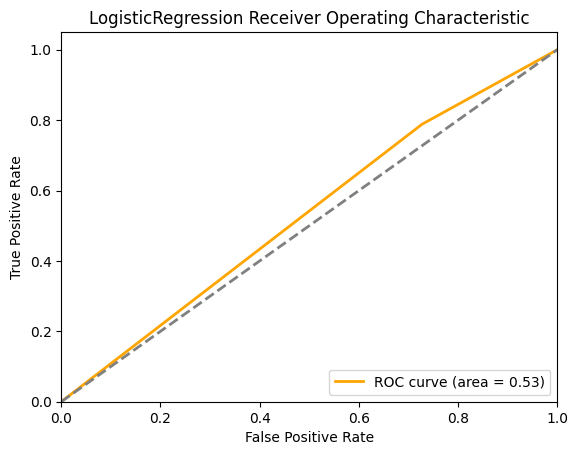

In [231]:
evaluate(y_test, lr_preds, lr_model, all_stats_accuracies)

#### Support Vector Machine

In [232]:
svm_model = svm.SVC()

In [233]:
svm_model.fit(X_train, y_train)

SVC()

In [234]:
svm_preds = svm_model.predict(X_test)

SVC Results
------------------------
 Accuracy: 57.31343%
Precision: 56.16438%
   Recall: 72.35294%
       F1: 63.23907%


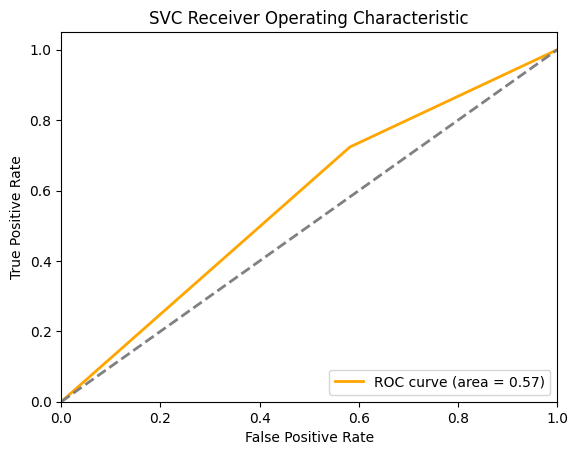

In [235]:
evaluate(y_test, svm_preds, svm_model, all_stats_accuracies)

#### Nearest Neighbors

**Nearest Centroid**

In [236]:
centroid_model = NearestCentroid()

In [237]:
centroid_model.fit(X_train, y_train)

NearestCentroid()

In [238]:
centroid_preds = centroid_model.predict(X_test)

NearestCentroid Results
------------------------
 Accuracy: 55.82090%
Precision: 56.17978%
   Recall: 58.82353%
       F1: 57.47126%


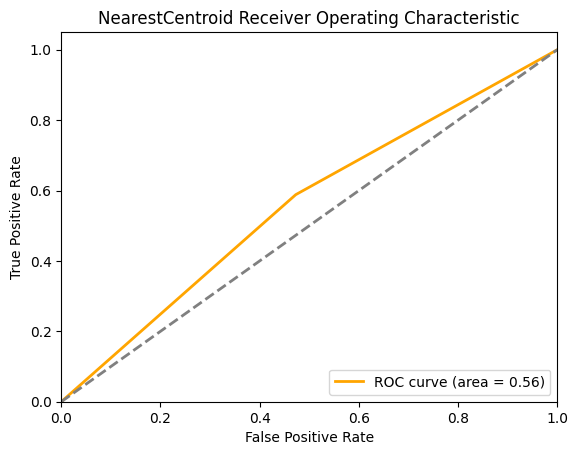

In [239]:
evaluate(y_test, centroid_preds, centroid_model, all_stats_accuracies)

***k*-Nearest Neighbors**

In [240]:
knn_model = KNeighborsClassifier()

In [241]:
param_grid = {"n_neighbors": [1, 2, 3, 5, 8, 13, 21, 34, 45, 79]}

In [242]:
grid_search = GridSearchCV(knn_model, param_grid, cv=5)

In [243]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 45, 79]})

In [244]:
best_n_neighbors = grid_search.best_params_["n_neighbors"]
print(f"Best n_neighbors value: {best_n_neighbors}")

Best n_neighbors value: 21


In [245]:
best_knn_classifier = grid_search.best_estimator_

In [246]:
knn_preds = best_knn_classifier.predict(X_test)

KNeighborsClassifier Results
------------------------
 Accuracy: 46.56716%
Precision: 47.69231%
   Recall: 54.70588%
       F1: 50.95890%


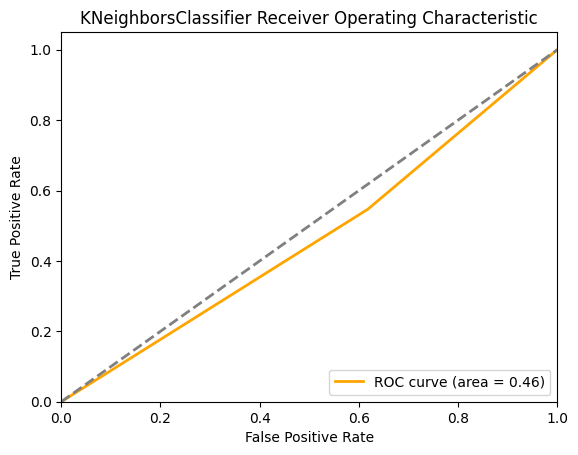

In [247]:
evaluate(y_test, knn_preds, best_knn_classifier, all_stats_accuracies)

**Gradient-Boosted Tree**

In [248]:
gbt_model = HistGradientBoostingClassifier(max_iter=100)

In [249]:
gbt_model.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [250]:
gbt_preds = gbt_model.predict(X_test)

HistGradientBoostingClassifier Results
------------------------
 Accuracy: 52.53731%
Precision: 52.91005%
   Recall: 58.82353%
       F1: 55.71031%


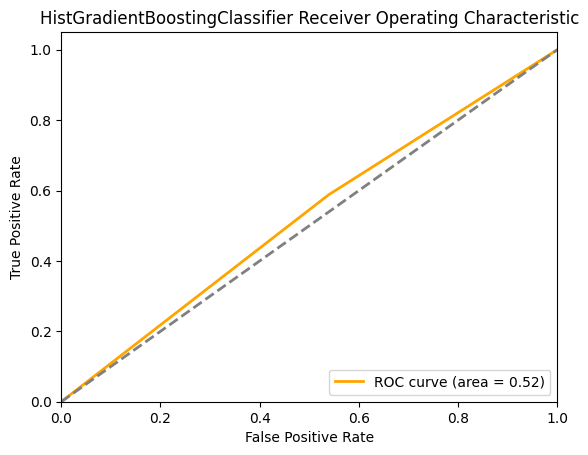

In [251]:
evaluate(y_test, gbt_preds, gbt_model, all_stats_accuracies)

## Modeling with Old-School Stats

The statistics used for this model will be: 
 - ERA
 - Wins
 - Losses
 - Win Percentage
 - Innings Pitched

### Data Preparation

In [252]:
old_school_features = [
    "pitcher_era_comp",
    "pitcher_win_percentage_comp",
    "pitcher_win_comp",
    "pitcher_losses_comp",
    "pitcher_innings_pitched_comp",
]

In [253]:
X_train, X_test, y_train, y_test = train_test_split(
    df[old_school_features],
    df["winning_team"],
    test_size=0.2,
    random_state=42,
)

In [254]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1338, 5)
X_test shape: (335, 5)
Y_train shape: (1338,)
Y_test shape: (335,)


### Model Experimentation

#### Logistic Regression

In [255]:
lr_model = LogisticRegression()

In [256]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [257]:
lr_preds = lr_model.predict(X_test)

LogisticRegression Results
------------------------
 Accuracy: 53.73134%
Precision: 52.85171%
   Recall: 81.76471%
       F1: 64.20323%


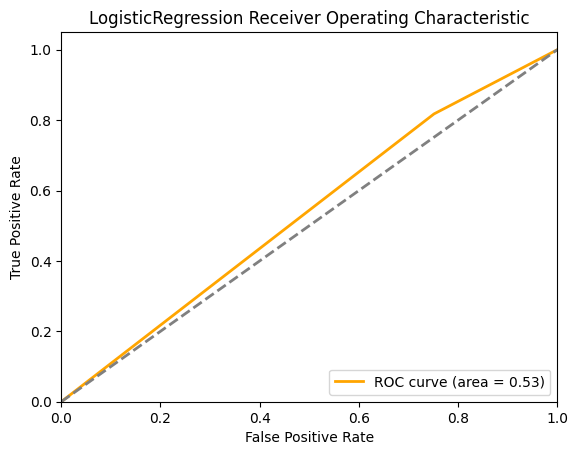

In [258]:
evaluate(y_test, lr_preds, lr_model, old_school_accuracies)

#### Support Vector Machine

In [259]:
svm_model = svm.SVC()

In [260]:
svm_model.fit(X_train, y_train)

SVC()

In [261]:
svm_preds = svm_model.predict(X_test)

SVC Results
------------------------
 Accuracy: 57.61194%
Precision: 56.48148%
   Recall: 71.76471%
       F1: 63.21244%


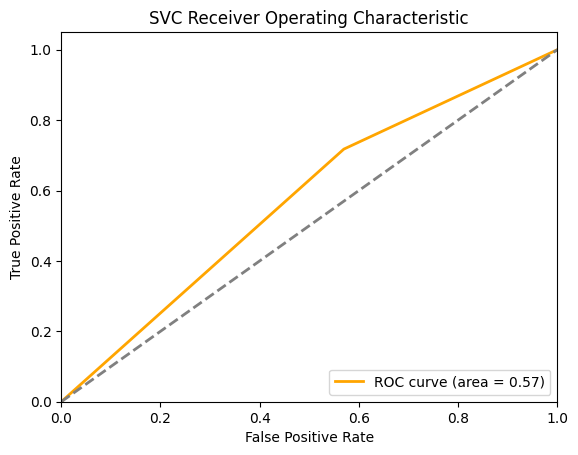

In [262]:
evaluate(y_test, svm_preds, svm_model, old_school_accuracies)

#### Nearest Neighbors

**Nearest Centroid**

In [263]:
centroid_model = NearestCentroid()

In [264]:
centroid_model.fit(X_train, y_train)

NearestCentroid()

In [265]:
centroid_preds = centroid_model.predict(X_test)

NearestCentroid Results
------------------------
 Accuracy: 57.91045%
Precision: 58.10056%
   Recall: 61.17647%
       F1: 59.59885%


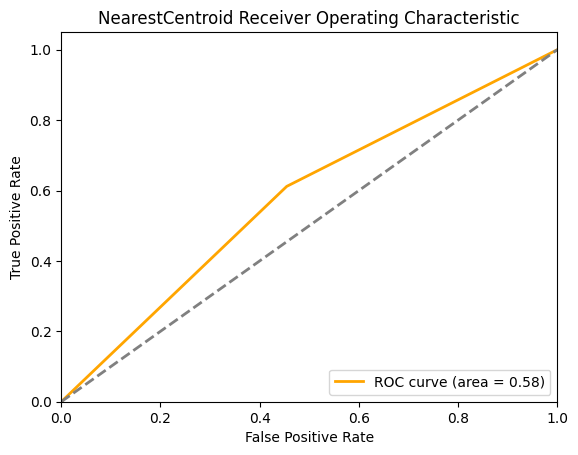

In [266]:
evaluate(y_test, centroid_preds, centroid_model, old_school_accuracies)

***k*-Nearest Neighbors**

In [267]:
knn_model = KNeighborsClassifier()

In [268]:
param_grid = {"n_neighbors": [1, 2, 3, 5, 8, 13, 21, 34, 45, 79]}

In [269]:
grid_search = GridSearchCV(knn_model, param_grid, cv=5)

In [270]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 45, 79]})

In [271]:
best_n_neighbors = grid_search.best_params_["n_neighbors"]
print(f"Best n_neighbors value: {best_n_neighbors}")

Best n_neighbors value: 79


In [272]:
best_knn_classifier = grid_search.best_estimator_

In [273]:
knn_preds = best_knn_classifier.predict(X_test)

KNeighborsClassifier Results
------------------------
 Accuracy: 58.20896%
Precision: 57.57576%
   Recall: 67.05882%
       F1: 61.95652%


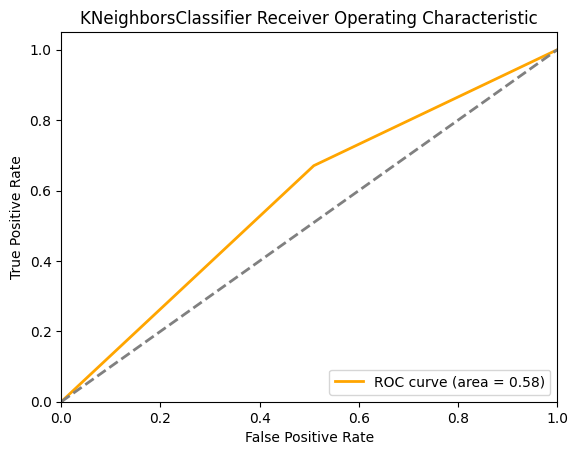

In [274]:
evaluate(y_test, knn_preds, best_knn_classifier, old_school_accuracies)

**Gradient-Boosted Tree**

In [275]:
gbt_model = HistGradientBoostingClassifier(max_iter=100)

In [276]:
gbt_model.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [277]:
gbt_preds = gbt_model.predict(X_test)

HistGradientBoostingClassifier Results
------------------------
 Accuracy: 55.82090%
Precision: 56.04396%
   Recall: 60.00000%
       F1: 57.95455%


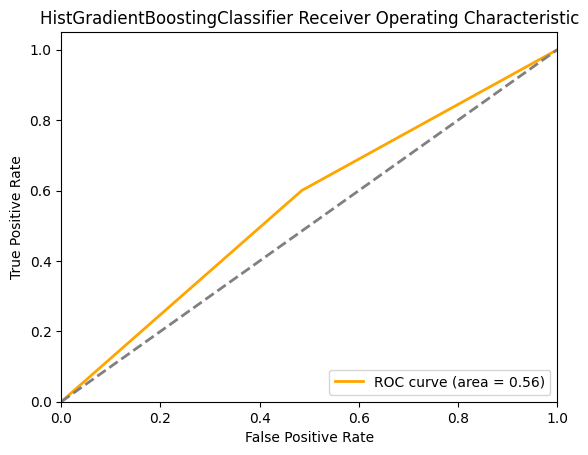

In [278]:
evaluate(y_test, gbt_preds, gbt_model, old_school_accuracies)

## Modeling with Modern Stats

The statistics used for this model will be: 
 - K/9
 - BB/9
 - K/9 - BB/9
 - WHIP
 - BABIP
 - K/9:BB/9 Ratio

### Data Preparation

In [279]:
modern_features = [
    "pitcher_k_nine_comp",
    "pitcher_bb_nine_comp",
    "pitcher_k_bb_diff_comp",
    "pitcher_whip_comp",
    "pitcher_babip_comp",
    "pitcher_k_bb_ratio_comp",
]

In [280]:
X_train, X_test, y_train, y_test = train_test_split(
    df[modern_features],
    df["winning_team"],
    test_size=0.2,
    random_state=42,
)

In [281]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1338, 6)
X_test shape: (335, 6)
Y_train shape: (1338,)
Y_test shape: (335,)


### Model Experimentation

#### Logistic Regression

In [282]:
lr_model = LogisticRegression()

In [283]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [284]:
lr_preds = lr_model.predict(X_test)

LogisticRegression Results
------------------------
 Accuracy: 55.52239%
Precision: 53.84615%
   Recall: 86.47059%
       F1: 66.36569%


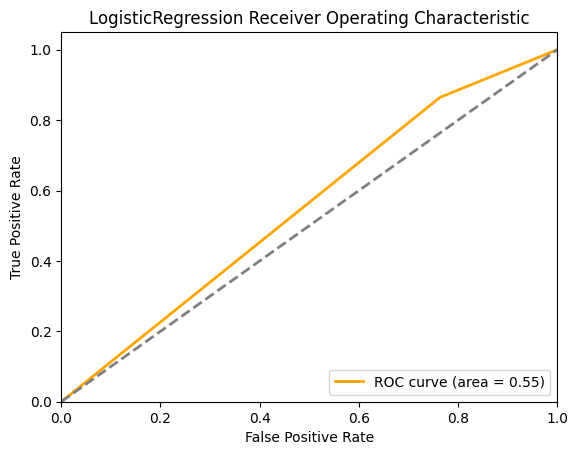

In [285]:
evaluate(y_test, lr_preds, lr_model, modern_accuracies)

#### Support Vector Machine

In [286]:
svm_model = svm.SVC()

In [287]:
svm_model.fit(X_train, y_train)

SVC()

In [288]:
svm_preds = svm_model.predict(X_test)

SVC Results
------------------------
 Accuracy: 52.23881%
Precision: 52.25225%
   Recall: 68.23529%
       F1: 59.18367%


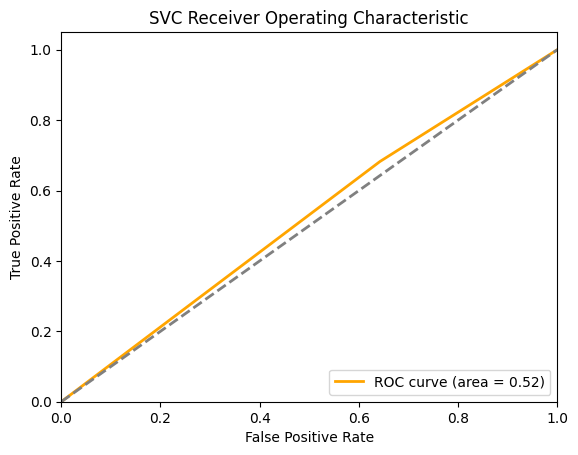

In [289]:
evaluate(y_test, svm_preds, svm_model, modern_accuracies)

#### Nearest Neighbors

**Nearest Centroid**

In [290]:
centroid_model = NearestCentroid()

In [291]:
centroid_model.fit(X_train, y_train)

NearestCentroid()

In [292]:
centroid_preds = centroid_model.predict(X_test)

NearestCentroid Results
------------------------
 Accuracy: 56.11940%
Precision: 56.64740%
   Recall: 57.64706%
       F1: 57.14286%


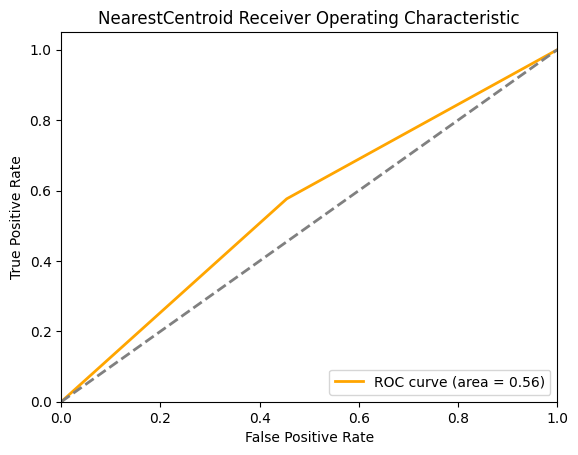

In [293]:
evaluate(y_test, centroid_preds, centroid_model, modern_accuracies)

***k*-Nearest Neighbors**

In [294]:
knn_model = KNeighborsClassifier()

In [295]:
param_grid = {"n_neighbors": [1, 2, 3, 5, 8, 13, 21, 34, 45, 79]}

In [296]:
grid_search = GridSearchCV(knn_model, param_grid, cv=5)

In [297]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 45, 79]})

In [298]:
best_n_neighbors = grid_search.best_params_["n_neighbors"]
print(f"Best n_neighbors value: {best_n_neighbors}")

Best n_neighbors value: 1


In [299]:
best_knn_classifier = grid_search.best_estimator_

In [300]:
knn_preds = best_knn_classifier.predict(X_test)

KNeighborsClassifier Results
------------------------
 Accuracy: 51.94030%
Precision: 52.35602%
   Recall: 58.82353%
       F1: 55.40166%


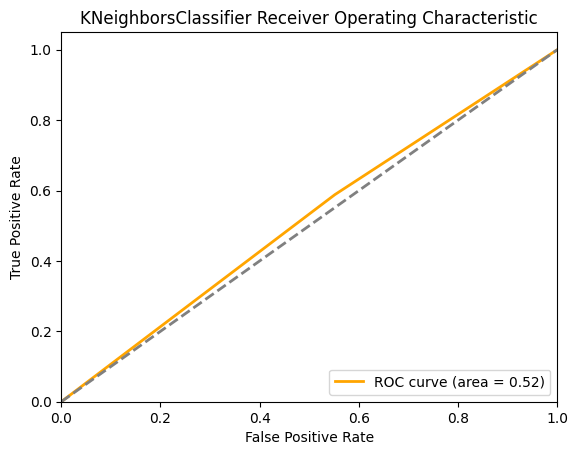

In [301]:
evaluate(y_test, knn_preds, best_knn_classifier, modern_accuracies)

**Gradient-Boosted Tree**

In [302]:
gbt_model = HistGradientBoostingClassifier(max_iter=100)

In [303]:
gbt_model.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [304]:
gbt_preds = gbt_model.predict(X_test)

HistGradientBoostingClassifier Results
------------------------
 Accuracy: 52.23881%
Precision: 52.71739%
   Recall: 57.05882%
       F1: 54.80226%


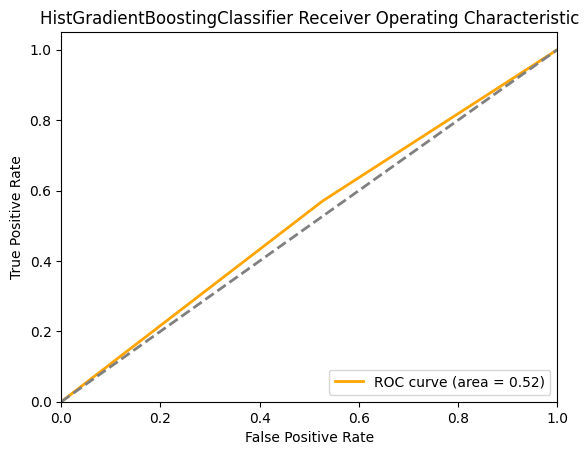

In [305]:
evaluate(y_test, gbt_preds, gbt_model, modern_accuracies)

## Noting the Best Classifiers

These classifiers will be used to go to production.

In [306]:
headers = ["Model", "Accuracy"]

In [307]:
best_all_stats_accuracy_entry = max(all_stats_accuracies, key=lambda x: x[2])
best_all_stats_classifier_name = best_all_stats_accuracy_entry[0]
best_all_stats_model = best_all_stats_accuracy_entry[1]
best_all_stats_accuracy_value = best_all_stats_accuracy_entry[2]

table_data = [(row[0], f"{row[2]:.2%}") for row in all_stats_accuracies]
table = tabulate(table_data, headers=headers, tablefmt="fancygrid")
print(table)

print()
print(f"Best All-Stats Model: {best_all_stats_classifier_name}")
print(f"            Accuracy: {best_all_stats_accuracy_value:.2%}")

Model                           Accuracy
------------------------------  ----------
LogisticRegression              53.43%
SVC                             57.31%
NearestCentroid                 55.82%
KNeighborsClassifier            46.57%
HistGradientBoostingClassifier  52.54%

Best All-Stats Model: SVC
            Accuracy: 57.31%


In [308]:
best_old_school_accuracy_entry = max(old_school_accuracies, key=lambda x: x[2])
best_old_school_classifier_name = best_old_school_accuracy_entry[0]
best_old_school_model = best_old_school_accuracy_entry[1]
best_old_school_accuracy_value = best_old_school_accuracy_entry[2]

table_data = [(row[0], f"{row[2]:.2%}") for row in old_school_accuracies]
table = tabulate(table_data, headers=headers, tablefmt="fancygrid")
print(table)

print()
print(f"Best Old-School Model: {best_old_school_classifier_name}")
print(f"             Accuracy: {best_old_school_accuracy_value:.2%}")

Model                           Accuracy
------------------------------  ----------
LogisticRegression              53.73%
SVC                             57.61%
NearestCentroid                 57.91%
KNeighborsClassifier            58.21%
HistGradientBoostingClassifier  55.82%

Best Old-School Model: KNeighborsClassifier
             Accuracy: 58.21%


In [309]:
best_modern_accuracy_entry = max(modern_accuracies, key=lambda x: x[2])
best_modern_classifier_name = best_modern_accuracy_entry[0]
best_modern_model = best_modern_accuracy_entry[1]
best_modern_accuracy_value = best_modern_accuracy_entry[2]

table_data = [(row[0], f"{row[2]:.2%}") for row in modern_accuracies]
table = tabulate(
    table_data,
    headers=headers,
    tablefmt="fancygrid",
)
print(table)

print()
print(f"Best Modern Model: {best_modern_classifier_name}")
print(f"         Accuracy: {best_modern_accuracy_value:.2%}")

Model                           Accuracy
------------------------------  ----------
LogisticRegression              55.52%
SVC                             52.24%
NearestCentroid                 56.12%
KNeighborsClassifier            51.94%
HistGradientBoostingClassifier  52.24%

Best Modern Model: NearestCentroid
         Accuracy: 56.12%


## Exporting the Best Model

In [310]:
now = datetime.datetime.now()

### All Stats

In [311]:
all_stats_object = (
    best_all_stats_model,
    {
        "date created": now,
        "model type": best_all_stats_classifier_name,
        "parameters used": ", ".join(all_stat_features),
        "accuracy": best_all_stats_accuracy_value,
        "training set size": X_train.shape[0],
        "testing set size": X_test.shape[0],
    },
)

In [312]:
all_stats_object

(SVC(),
 {'date created': datetime.datetime(2024, 1, 28, 20, 21, 48, 47509),
  'model type': 'SVC',
  'parameters used': 'pitcher_era_comp, pitcher_win_percentage_comp, pitcher_win_comp, pitcher_losses_comp, pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp, pitcher_k_bb_ratio_comp',
  'accuracy': 0.573134328358209,
  'training set size': 1338,
  'testing set size': 335})

### Old-School Stats

In [313]:
old_school_object = (
    best_old_school_model,
    {
        "date created": now,
        "model type": best_old_school_classifier_name,
        "parameters used": ", ".join(old_school_features),
        "accuracy": best_old_school_accuracy_value,
        "training set size": X_train.shape[0],
        "testing set size": X_test.shape[0],
    },
)

In [314]:
old_school_object

(KNeighborsClassifier(n_neighbors=79),
 {'date created': datetime.datetime(2024, 1, 28, 20, 21, 48, 47509),
  'model type': 'KNeighborsClassifier',
  'parameters used': 'pitcher_era_comp, pitcher_win_percentage_comp, pitcher_win_comp, pitcher_losses_comp, pitcher_innings_pitched_comp',
  'accuracy': 0.582089552238806,
  'training set size': 1338,
  'testing set size': 335})

### Modern Stats

In [315]:
modern_stats_object = (
    best_modern_model,
    {
        "date created": now,
        "model type": best_modern_classifier_name,
        "parameters used": ", ".join(modern_features),
        "accuracy": best_modern_accuracy_value,
        "training set size": X_train.shape[0],
        "testing set size": X_test.shape[0],
    },
)

In [316]:
modern_stats_object

(NearestCentroid(),
 {'date created': datetime.datetime(2024, 1, 28, 20, 21, 48, 47509),
  'model type': 'NearestCentroid',
  'parameters used': 'pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp, pitcher_k_bb_ratio_comp',
  'accuracy': 0.5611940298507463,
  'training set size': 1338,
  'testing set size': 335})

### Writing Out

In [317]:
filename = "model_objects/current_models.pkl"

In [318]:
models_object = (all_stats_object, old_school_object, modern_stats_object)

In [319]:
pprint.pprint(models_object)

((SVC(),
  {'accuracy': 0.573134328358209,
   'date created': datetime.datetime(2024, 1, 28, 20, 21, 48, 47509),
   'model type': 'SVC',
   'parameters used': 'pitcher_era_comp, pitcher_win_percentage_comp, '
                      'pitcher_win_comp, pitcher_losses_comp, '
                      'pitcher_innings_pitched_comp, pitcher_k_nine_comp, '
                      'pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, '
                      'pitcher_whip_comp, pitcher_babip_comp, '
                      'pitcher_k_bb_ratio_comp',
   'testing set size': 335,
   'training set size': 1338}),
 (KNeighborsClassifier(n_neighbors=79),
  {'accuracy': 0.582089552238806,
   'date created': datetime.datetime(2024, 1, 28, 20, 21, 48, 47509),
   'model type': 'KNeighborsClassifier',
   'parameters used': 'pitcher_era_comp, pitcher_win_percentage_comp, '
                      'pitcher_win_comp, pitcher_losses_comp, '
                      'pitcher_innings_pitched_comp',
   'testing set size': 335,
   '

In [320]:
with open(filename, "wb") as file:
    pickle.dump(models_object, file)